# Varying Width Analysis

In [2]:

import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [41]:
def group_data_by_metric(directory):
    # Pattern looks for - or _ followed by digits then 'mm'
    metric_pattern = re.compile(r"[-_](\d+)mm", re.IGNORECASE)

    # Storage: {metric: [(distance_array, counts_array), ...]}
    grouped_data = {}

    for fname in os.listdir(directory):
        if not fname.endswith(".dat"):
            continue

        match = metric_pattern.search(fname)
        if not match:
            continue # Skip files that don't have the w-Xmm metric

        metric = match.group(1)
        # print(metric)

        # --- Your existing reading logic ---
        data = pd.read_csv(
            os.path.join(directory, fname),
            sep=r"\s+",
            skiprows=1,
            names=["Distance", "Counts"]
        )
        dist_array = data["Distance"].to_numpy()

        midpoint = (dist_array[-1] - dist_array[0])/2
        dist_array = dist_array - midpoint

        counts_array = data["Counts"].to_numpy()
        # -----------------------------------

        if metric not in grouped_data:
            grouped_data[metric] = []

        # Add a tuple of the two arrays to the list for this metric
        grouped_data[metric].append((dist_array, counts_array))

    return grouped_data

def plot(grouped_data, savename):
    plt.figure()
    plt.title("Sweep Counts for Different Widths")
    plt.xlabel("Displacement (mm)")
    plt.ylabel("Counts")

    for metric in sorted(grouped_data.keys()):
        data_list = grouped_data[metric]

        # data_list is a list of tuples: (distance_array, counts_array)
        for dist, counts in data_list:

            plt.plot(dist, counts, label=f"counts for width = {metric}mm")

    plt.legend()
    plt.savefig(savename)
    plt.show()

def normalize(grouped_data):
    for metric in grouped_data:
        data_list = grouped_data[metric]
        normalized_list = []

        for dist, counts in data_list:
            max_val = np.max(counts) # Use np.max for arrays
            normalized_counts = counts / max_val
            normalized_list.append((dist, normalized_counts))

        # Keep it as a list of tuples
        grouped_data[metric] = normalized_list

    return grouped_data

def getFWHM(normed_group_data):
    grouped_fwhm = {}

    for metric in normed_group_data:
        data_list = normed_group_data[metric]
        normalized_list = []

        for dist, counts in data_list:
            fwhm, r0, r1 = get_fwhm(dist, counts)
            normalized_list.append((fwhm, r0, r1))

        # Keep it as a list of tuples
        grouped_fwhm[metric] = normalized_list

    return grouped_fwhm

def get_fwhm(x, y):
    # 1. Normalize and center at 0.5
    spline = UnivariateSpline(x, y - 0.5, s=0)

    # 2. Find the roots (where y_norm - 0.5 = 0)
    roots = spline.roots()

    if len(roots) >= 2:
        # Assuming the two outermost roots are the ones we want
        fwhm = abs(roots[-1] - roots[0])
        return fwhm, roots[0], roots[-1]
    return None, None, None

In [42]:

# Usage
WidthCalibrationJan14 = group_data_by_metric("./data/Width calibration - 2026-01-14")
# display(WidthCalibrationJan14)
WidthCalibrationJan14 = normalize(WidthCalibrationJan14)
# display(WidthCalibrationJan14)

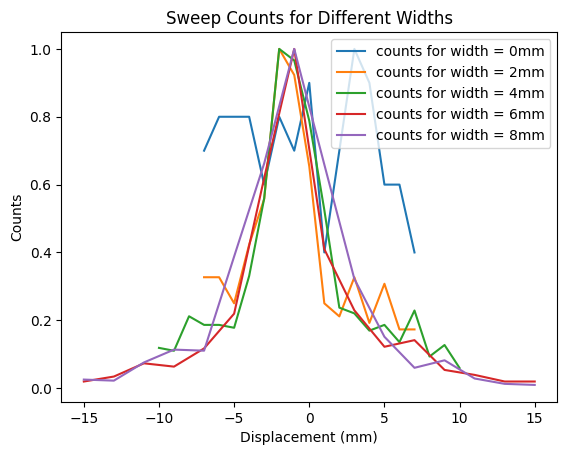

In [43]:
plot(WidthCalibrationJan14, "Width Calibration Jan14")

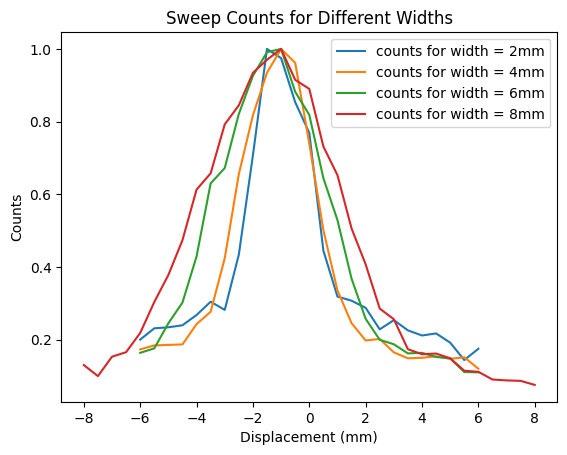

In [44]:
WidthCalibrationJan16 = group_data_by_metric("./data/Resolution Measurements - 2026-01-16")
WidthCalibrationJan16 = normalize(WidthCalibrationJan16)
plot(WidthCalibrationJan16, "Width Calibration Jan16")